In [1]:
#from nsepy import get_history # to fetch the data of the stock from NSE, India 
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler  # library required for scaling the data
import pandas as pd
import quandl

In [2]:
quandl.connection.ApiConfig.api_key= "_N85bWLCNCWz14smKHSi"

In [3]:
start = date(2015,1,1)
end= date.today()

In [4]:
data = quandl.get('NSE/SBIN',start_date=start,end_date=end)
#data1= quandl.get('ECB/RTD_M_S0_N_C_SP500_X', start_date=start,end_date=end)

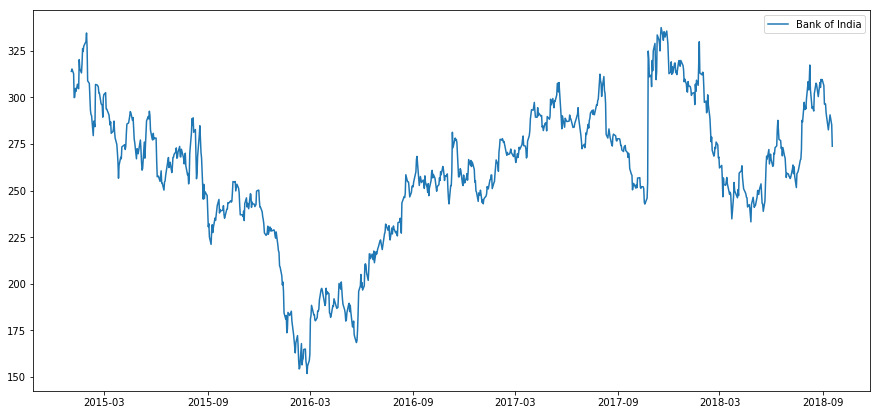

In [5]:
plt.figure(figsize=(15,7))
plt.plot(data.Close, label='Bank of India')
plt.legend()
plt.show()

In [6]:
data.head()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2015-01-01,312.45,315.00,310.70,314.0,314.00,6138488.0,19254.89
2015-01-02,314.35,318.30,314.35,315.6,315.25,9935094.0,31473.89
2015-01-05,316.25,316.80,312.10,312.8,312.75,9136716.0,28674.32
2015-01-06,310.00,311.10,298.70,299.9,299.90,15329257.0,46776.01
2015-01-07,300.00,302.55,295.15,301.4,300.15,15046745.0,45132.43


In [7]:
# Specify the test data size
test_size=60
# To avoid any look forward bias we will be taking only the train data to scale the data
max_=data.iloc[:-test_size][['Open','High','Low','Close']].max().max() #Using .max() once gives the maximum values of each column
min_=data.iloc[:-test_size][['Open','High','Low','Close']].min().min()
max_,min_

(351.3, 148.25)

In [8]:
scl=MinMaxScaler()

In [9]:
X1=(data[['Open','High','Low','Close']]-min_)/(max_-min_)
scl.fit(data[['Total Trade Quantity']].iloc[:-test_size].values.reshape(-1,1))
X2=scl.transform(data[['Total Trade Quantity']].values.reshape(-1,1))
X1=np.array(X1)

data=data.assign(Open=X1[:,0])
data=data.assign(High=X1[:,1])
data=data.assign(Low=X1[:,2])
data=data.assign(Close=X1[:,3])
data=data.assign(Volume=X2[:,0])
data.tail()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),Volume
Date,,,,,,,,
2018-09-11,0.685053,0.705245,0.656981,282.00,0.661660,28361400.0,81437.74,0.100914
2018-09-12,0.668555,0.681852,0.648855,285.85,0.674957,22717796.0,64431.65,0.079259
2018-09-14,0.698596,0.706969,0.691702,290.65,0.701305,15149585.0,43978.39,0.050219
2018-09-17,0.690717,0.690717,0.669047,285.10,0.674957,16089996.0,45974.26,0.053828
2018-09-18,0.673479,0.682837,0.611426,273.60,0.618321,33901000.0,94012.20,0.122170


In [10]:
X1[-5:]

array([[0.68505294, 0.70524501, 0.65698104, 0.66165969],
       [0.66855454, 0.68185176, 0.64885496, 0.67495691],
       [0.6985964 , 0.70696873, 0.69170155, 0.7013051 ],
       [0.69071657, 0.69071657, 0.66904703, 0.67495691],
       [0.67347944, 0.68283674, 0.61142576, 0.61832061]])

### <span style="color:brown">Creating feature and target datasets</span>

Now,we will create a feature data set called  <font color =red>X</font> which will be used to create the input for the RNN model.<br> 

Next, we create a dataset called <font color =red>y</font> which will contain the future close values.<br>

The model will train to predict these values future close prices.

In [11]:
X=data[['Open','High','Low','Close','Volume']]
y=data.Last.shift(-1)

In this example, I have taken a timestep of 20 days to create the input data. By doing this, we will feed the past 20-days of data at every time step to the RNN. We can change the target data to predict the next 5 days, by changing the code to contain y_list.append(y.iloc[i:i+5]), then you can predict a sequence of 5 days data.

In [40]:
timestep=20
X_list=[]
y_list=[]
for i in range(timestep,len(X)):
    X_list.append(np.array(X.iloc[i-timestep:i]))
    y_list.append(y.iloc[i])
    #y_list.append(y.iloc[i:i+5])

In [41]:
X_train=np.array(X_list)[:-test_size]
y_train=np.array(y_list)[:-test_size]
X_test=np.array(X_list)[-test_size:]
y_test=np.array(y_list)[-test_size:]

In [42]:
X_train.shape, y_train.shape

((841, 20, 5), (841,))

In [43]:
y_train[:1]

array([308.5])

### <span style="color:brown"> Creating an RNN model

In [44]:
from keras.layers import SimpleRNN
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

In [45]:
dropout_ratio=0.5

In [46]:
model=Sequential()
model.add(SimpleRNN(timestep,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dense(32))
model.add(Dropout(dropout_ratio))
model.add(Dense(64))
model.add(Dropout(dropout_ratio))
model.add(Dense(128))
model.add(Dropout(dropout_ratio))
model.add(Dense(256))
model.add(Dropout(dropout_ratio))
model.add(Dense(512))
model.add(Dropout(dropout_ratio))
model.add(Dense(1024))
model.add(Dropout(dropout_ratio))
model.add(Dense(2048))
model.add(Dropout(dropout_ratio))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [47]:
filepath="RNN-weights-best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [48]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 20)                520       
_________________________________________________________________
dense_9 (Dense)              (None, 32)                672       
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
__________

In [51]:
training=model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=1, validation_split=0.2,callbacks=[checkpoint])

Train on 672 samples, validate on 169 samples
Epoch 1/100
672/672 [==============================] - 2s 3ms/step - loss: 33945.4138 - val_loss: 12230.0160

Epoch 00001: val_loss improved from inf to 12230.01605, saving model to RNN-weights-best.hdf5
Epoch 2/100
672/672 [==============================] - 1s 1ms/step - loss: 12929.7070 - val_loss: 2410.6115

Epoch 00002: val_loss improved from 12230.01605 to 2410.61154, saving model to RNN-weights-best.hdf5
Epoch 3/100
672/672 [==============================] - 1s 1ms/step - loss: 9231.2756 - val_loss: 274.2279

Epoch 00003: val_loss improved from 2410.61154 to 274.22789, saving model to RNN-weights-best.hdf5
Epoch 4/100
672/672 [==============================] - 1s 1ms/step - loss: 6645.7587 - val_loss: 1078.7069

Epoch 00004: val_loss did not improve from 274.22789
Epoch 5/100
672/672 [==============================] - 1s 1ms/step - loss: 6352.6725 - val_loss: 1189.9050

Epoch 00005: val_loss did not improve from 274.22789
Epoch 6/100


672/672 [==============================] - 1s 1ms/step - loss: 770.4106 - val_loss: 253.6593

Epoch 00050: val_loss did not improve from 181.57649
Epoch 51/100
672/672 [==============================] - 1s 1ms/step - loss: 726.3094 - val_loss: 193.1891

Epoch 00051: val_loss did not improve from 181.57649
Epoch 52/100
672/672 [==============================] - 1s 1ms/step - loss: 705.5975 - val_loss: 286.6404

Epoch 00052: val_loss did not improve from 181.57649
Epoch 53/100
672/672 [==============================] - 1s 1ms/step - loss: 663.7337 - val_loss: 198.1974

Epoch 00053: val_loss did not improve from 181.57649
Epoch 54/100
672/672 [==============================] - 1s 1ms/step - loss: 617.8684 - val_loss: 179.8233

Epoch 00054: val_loss improved from 181.57649 to 179.82326, saving model to RNN-weights-best.hdf5
Epoch 55/100
672/672 [==============================] - 1s 1ms/step - loss: 583.6452 - val_loss: 238.5196

Epoch 00055: val_loss did not improve from 179.82326
Epoch 56

672/672 [==============================] - 1s 1ms/step - loss: 539.7560 - val_loss: 166.8396

Epoch 00100: val_loss did not improve from 142.58876


In [52]:
training.history.keys()

dict_keys(['val_loss', 'loss'])

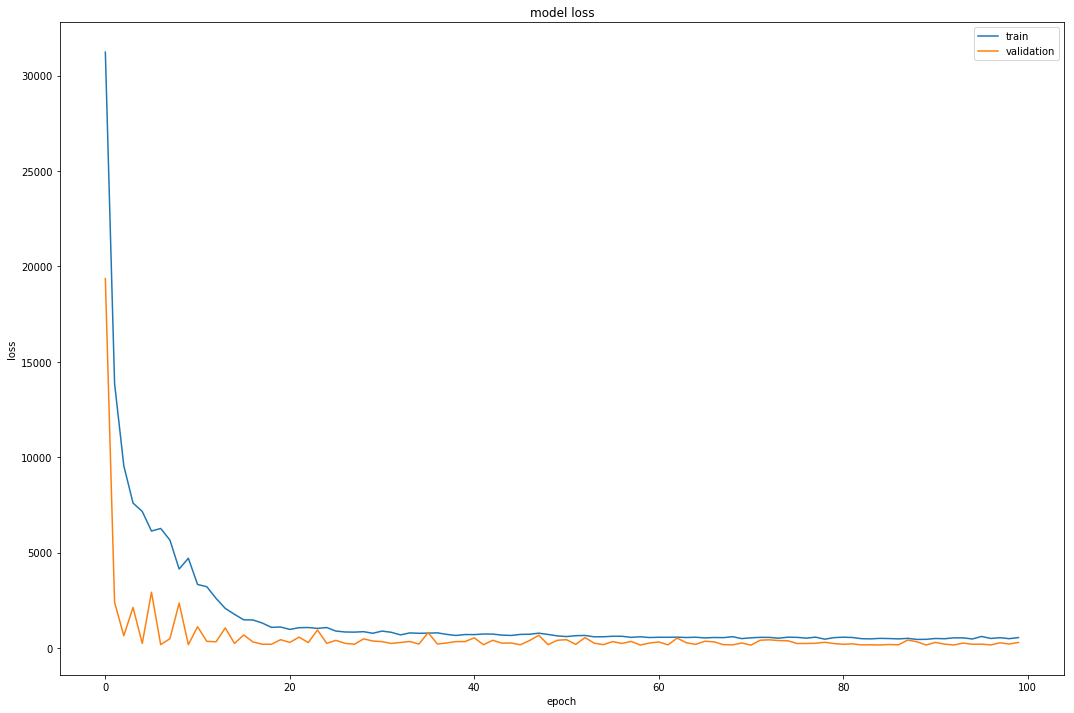

In [84]:
# summarize history for loss
plt.figure(figsize=(18,12))
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [85]:
model.load_weights("RNN-weights-best.hdf5")

In [86]:
predict_close=[]
predict_close=np.reshape(model.predict(X_test),(1,-1))

In [87]:
predict_close.shape

(1, 60)

In [88]:
predict_close=predict_close[0]

In [89]:
performance=pd.DataFrame([predict_close,y_test])

In [90]:
# Since the two vectors are added as rows, we take the transpose of the dataframe to create the appropriate columns
performance=performance.T

In [91]:
performance.columns=['Predicted','Actual']
Spread=performance.Actual-performance.Predicted
performance.tail()

,Predicted,Actual
55,287.565277,285.85
56,285.610657,290.65
57,283.099243,285.10
58,288.407562,273.60
59,287.780487,NaN


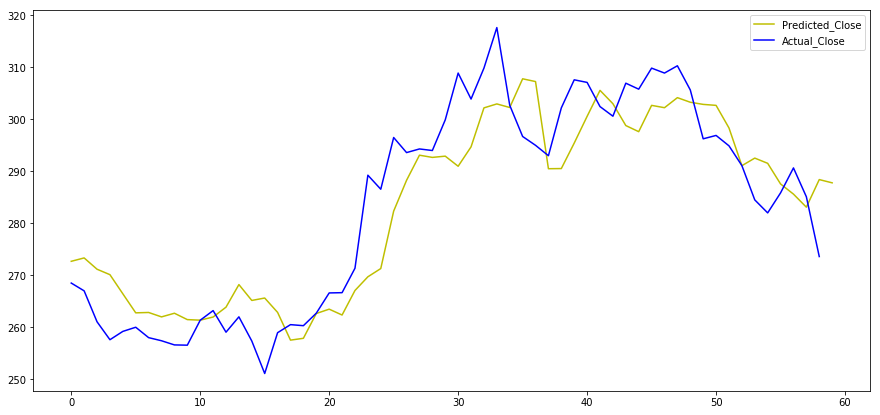

In [92]:
plt.figure(figsize=(15,7))
plt.plot(predict_close,c='y')
plt.plot(y_test.tolist(),c='b')
plt.legend(['Predicted_Close','Actual_Close'])
plt.show()

In [93]:
from sklearn.metrics import mean_squared_error
from math import sqrt


In [94]:
rmse = sqrt(mean_squared_error(y_test.tolist()[:-1], predict_close[:-1]))
print('RMSE: %.3f' % rmse)

RMSE: 8.089


In [95]:
len(y_test.tolist()[:-1])

59

In [96]:
len(predict_close[:-1])

59